In [1]:
import pandas as pd
# import glob
# import os
import pickle
from nltk.metrics.scores import f_measure
# from nltk.collocations import BigramCollocationFinder
# from nltk.metrics import BigramAssocMeasures
# from nltk.probability import FreqDist, ConditionalFreqDist
from tqdm import tqdm
# from gensim.utils import simple_preprocess
# import re
# from sklearn import metrics
import nltk
from nltk.corpus import stopwords
import collections, itertools
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
# import matplotlib as mpl
# from tqdm import tqdm
# from itertools import chain
# import unidecode
import numpy as np
# from os import listdir
# from os.path import isfile, join
import matplotlib.pyplot as plt
from nltk.classify import NaiveBayesClassifier
import spacy
# nlp = spacy.load("nl_core_news_sm", disable=["ner"])

In [39]:

import collections, itertools
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.metrics.scores import f_measure
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from tqdm import tqdm

In [31]:
%matplotlib inline

#TODO move lemmatization to preparation cigarette corpus

In [25]:
data_path = '../data/processed/'
figures_path = '../ms/figures/'

nlp = spacy.load("nl_core_news_sm", disable=["ner"])

with open('../data/nl_dictionary.pkl', 'rb') as f:
    dictionary_nl = pickle.load(f)
    
stop_words = list(set(stopwords.words('dutch')))

extra_stop_words = ['xcxbb','xcxa', 'xcxab', 'xexxa', 'xexxaxexxa', 'xexx', 'xexxaxexxaxexxa', 'amerikaanse', 'americas',
                    'xcx', 'xexxe', 'xexxaxexxaxexxaxexxa', 'xcxaf', 'xcxb', 'xcxbc', 'xcxaxcxan', 'medadvertentie', 'americano',
                     'xexxaxexxaxexxaxexxaxexxa', 'xexxaxcxbb', 'xexxxexx', 'xcxc', 'xcxabxexxa', 'amerika', 'cigaret',
                     'xexxxexxa', 'xcxaxexxa', 'xexxaxcxa', 'xcxbbxexxa', 'xexxaxcxab', 'xcxaxcxa', 'amerikanen'
                    'xexxaxexx', 'xcxabxcxbb', 'xcxbbxcxbb', 'xcxabi', 'xcxabn', 'xcxabxcxab', 'badvertentie', 'usa',
                    'xexxexexxe', 'xcxbxcxbk', 'xcxan', 'xexxxexxxexx', 'den', 'sigaretten', 'sigaret', 'advertentie', 'ingez',
                   'koop', 'tel', 'kunt', 'the','wij', 'amerikaan', 'virginia', 'american', 'cigarette', 'cigarettes']

stop_words.extend(extra_stop_words)

In [26]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ','ADV', 'VERB']):
    print('lemmatizing!')
    nlp = spacy.load('nl_core_news_sm', disable=['parser', 'ner'])
    text_clean = []
    for sent in tqdm(texts):
        doc = nlp(sent)
        text_clean.append(' '.join([str(token) for token in doc if token.pos_ in allowed_postags]))
    return text_clean


def tfidf_feats(words, word_list):
    return dict([(word, True) for word in words if word in word_list])

def find_best_tf_idf(corpus_list, top_n_words=1000):

    best_tf_idf = []
    for corpus in corpus_list:

        vectorizer = TfidfVectorizer(norm='l1', sublinear_tf=True, analyzer='word', ngram_range=(1,5),
                                           stop_words=stop_words)
        tfidf_matrix =  vectorizer.fit_transform(corpus['ocr'])
        scores = zip(vectorizer.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        feature_list = []
        counter = 0
        if top_n_words > len(sorted_scores):
            top_n_words = len(sorted_scores)
        for item in sorted_scores:
            if counter > top_n_words:
                break
            else:
                if len(item[0]) > 2:
                    feature_list.append(item[0])
                    counter +=1 
    best_tf_idf.extend(feature_list)   
    return list(set(best_tf_idf))

def classify(trainfeats, testfeats):
    classifier = NaiveBayesClassifier.train(trainfeats)
    refsets = collections.defaultdict(set)
    testsets = collections.defaultdict(set)
    labels = []
    for i, (feats, label) in enumerate(testfeats):
        labels.append(label)
        refsets[label].add(i)
        observed = classifier.classify(feats)
        testsets[observed].add(i)
        
    print('accuracy: {}'.format(nltk.classify.util.accuracy(classifier, testfeats)))
    print('American F-measure: {}'.format(f_measure(refsets['american'], testsets['american'])))
    print('Virginia F-measure: {}'.format(f_measure(refsets['virginia'], testsets['virginia'])))
    
    f_score = (f_measure(refsets['american'], testsets['american']), f_measure(refsets['virginia'], testsets['virginia']))
    
    classifier.show_most_informative_features(150)
    return f_score

def remove_stopwords(texts):
    '''
    remove accents and increase max length of words
    Dutch has longer words than English
    '''
    return ' '.join(word for word in simple_preprocess(str(texts), max_len=17) if word not in stop_words)

In [32]:
cigarette_corpus = pd.read_csv(os.path.join(data_path, 'cigarette_corpus.tsv'))
cigarette_corpus['words'] = cigarette_corpus['ocr'].apply(lambda x: x.lower().split())

In [33]:
cigarette_corpus.shape[0]

43781

In [ ]:
cigarette_corpus['clean'] = lemmatization(cigarette_corpus['ocr'])

In [35]:
cigarette_corpus['date'] = pd.to_datetime(cigarette_corpus['date'])

In [ ]:
cigarette_corpus['words'] = cigarette_corpus['clean'].apply(lambda x: x.lower().split())

In [37]:
start_date = pd.to_datetime('01/01/1920'.format(i))
end_date = pd.to_datetime('31/12/1940'.format(i))
corpus_a = cigarette_corpus[cigarette_corpus['date'].between(start_date, end_date)]

american_corpus = corpus_a[(corpus_a['american'] == 1) & ((corpus_a['virginia'] == 0) | (corpus_a['british'] == 0))]
virginia_corpus = corpus_a[(corpus_a['american'] == 0) & ((corpus_a['virginia'] == 1) | (corpus_a['british'] == 1))]

tf_idf_words = find_best_tf_idf([american_corpus, virginia_corpus], 5000)

american_features = [(tfidf_feats(doc, tf_idf_words), 'american') for doc in american_corpus['words']]
virginia_features = [(tfidf_feats(doc, tf_idf_words), 'virginia') for doc in virginia_corpus['words']]

american_cutoff = int(len(american_features)*4/5)
virginia_cutoff = int(len(virginia_features)*4/5)

trainfeats = american_features[:american_cutoff] + virginia_features[:virginia_cutoff] 
testfeats = american_features[american_cutoff:] + virginia_features[virginia_cutoff:]

classify(trainfeats, testfeats)


NameError: name 'i' is not defined

In [82]:
f_measures = []
for i in range(2, 9,):
    print(f'19{i}0')
    print('----------')
    start_date = pd.to_datetime('01/01/19{}0'.format(i))
    end_date = pd.to_datetime('31/12/19{}9'.format(i))
    corpus_a = cigarette_corpus[cigarette_corpus['date'].between(start_date, end_date)]
    
    american_corpus = corpus_a[(corpus_a['american'] == 1) & ((corpus_a['virginia'] == 0) | (corpus_a['british'] == 0))]
    virginia_corpus = corpus_a[(corpus_a['american'] == 0) & ((corpus_a['virginia'] == 1) | (corpus_a['british'] == 1))]
    
    tf_idf_words = find_best_tf_idf([american_corpus, virginia_corpus], 2000)
    
    american_features = [(tfidf_feats(doc, tf_idf_words), 'american') for doc in american_corpus['words']]
    virginia_features = [(tfidf_feats(doc, tf_idf_words), 'virginia') for doc in virginia_corpus['words']]
    
    american_cutoff = int(len(american_features)*3/4)
    virginia_cutoff = int(len(virginia_features)*3/4)
    
    trainfeats = american_features[:american_cutoff] + virginia_features[:virginia_cutoff] 
    testfeats = american_features[american_cutoff:] + virginia_features[virginia_cutoff:]
    
    f_score = classify(trainfeats, testfeats)
    f_measures.append(f_score)
    

1920
----------
accuracy: 0.6914893617021277
American F-measure: 0.25641025641025644
Virginia F-measure: 0.8053691275167785
Most Informative Features
                   geven = True           americ : virgin =     24.4 : 1.0
                    doos = True           americ : virgin =     19.0 : 1.0
                  overal = True           americ : virgin =     13.5 : 1.0
                    miss = True           americ : virgin =     11.4 : 1.0
                  alleen = True           americ : virgin =      8.1 : 1.0
                    tijd = True           americ : virgin =      8.1 : 1.0
                     oud = True           americ : virgin =      8.1 : 1.0
            gegarandeerd = True           americ : virgin =      8.1 : 1.0
                  rooken = True           americ : virgin =      8.1 : 1.0
                     adv = True           americ : virgin =      8.1 : 1.0
               rotterdam = True           americ : virgin =      6.7 : 1.0
                    haag 

accuracy: 0.5869565217391305
American F-measure: 0.5581395348837209
Virginia F-measure: 0.6122448979591837
Most Informative Features
                   beste = True           virgin : americ =      7.1 : 1.0
              gezondheid = True           virgin : americ =      5.5 : 1.0
                mondstuk = True           virgin : americ =      5.2 : 1.0
                 slechts = True           americ : virgin =      4.7 : 1.0
                    rook = True           virgin : americ =      4.1 : 1.0
                 fijnste = True           virgin : americ =      3.6 : 1.0
            gegarandeerd = True           virgin : americ =      3.6 : 1.0
                 doosjes = True           virgin : americ =      3.6 : 1.0
             voorburgwal = True           virgin : americ =      3.6 : 1.0
                    made = True           virgin : americ =      3.6 : 1.0
                  nieuwe = True           virgin : americ =      2.8 : 1.0
                  versch = True           

accuracy: 0.6875
American F-measure: 0.7619047619047619
Virginia F-measure: 0.5454545454545454
Most Informative Features
                    naam = True           virgin : americ =      7.8 : 1.0
              verzending = True           virgin : americ =      6.4 : 1.0
                  alleen = True           virgin : americ =      5.0 : 1.0
                 prijzen = True           virgin : americ =      5.0 : 1.0
               indonesie = True           virgin : americ =      5.0 : 1.0
                afdeling = True           virgin : americ =      3.6 : 1.0
                voorraad = True           virgin : americ =      3.6 : 1.0
                   dient = True           virgin : americ =      3.6 : 1.0
                  blijft = True           virgin : americ =      3.6 : 1.0
                  echter = True           virgin : americ =      3.6 : 1.0
                    pijp = True           virgin : americ =      3.6 : 1.0
                   stelt = True           virgin : ame

accuracy: 0.7834394904458599
American F-measure: 0.7364341085271318
Virginia F-measure: 0.8162162162162162
Most Informative Features
               volmaakte = True           virgin : americ =     52.9 : 1.0
                    pure = True           virgin : americ =     34.1 : 1.0
                  krijgt = True           virgin : americ =     26.6 : 1.0
                 product = True           virgin : americ =     17.2 : 1.0
              verpakking = True           virgin : americ =     12.2 : 1.0
                vrienden = True           americ : virgin =     11.7 : 1.0
                 egberts = True           americ : virgin =     11.0 : 1.0
                  gezien = True           virgin : americ =     10.3 : 1.0
                  gouden = True           virgin : americ =     10.3 : 1.0
                     ets = True           virgin : americ =      9.7 : 1.0
                   steek = True           virgin : americ =      9.7 : 1.0
                     zie = True           

accuracy: 0.4
American F-measure: 0.5512820512820512
Virginia F-measure: 0.09482758620689655
Most Informative Features
                   album = True           virgin : americ =    169.5 : 1.0
                  moeite = True           virgin : americ =    169.5 : 1.0
                   halen = True           virgin : americ =    169.5 : 1.0
                  willem = True           virgin : americ =    129.6 : 1.0
              aangegeven = True           virgin : americ =    109.7 : 1.0
                   serie = True           virgin : americ =    109.7 : 1.0
                compleet = True           virgin : americ =    101.7 : 1.0
                  brengt = True           virgin : americ =     69.8 : 1.0
                  bestel = True           virgin : americ =     65.8 : 1.0
                  doosje = True           virgin : americ =     65.8 : 1.0
                     zit = True           virgin : americ =     65.8 : 1.0
                 kleuren = True           virgin : ameri

accuracy: 0.5892857142857143
American F-measure: 0.7012987012987012
Virginia F-measure: 0.3428571428571428
Most Informative Features
                    oude = True           virgin : americ =     42.6 : 1.0
            specialisten = True           virgin : americ =     42.6 : 1.0
                 laurens = True           virgin : americ =     30.9 : 1.0
             continental = True           virgin : americ =     27.9 : 1.0
                 fabriek = True           virgin : americ =     25.6 : 1.0
               vakmensen = True           virgin : americ =     25.6 : 1.0
                  senior = True           virgin : americ =     15.7 : 1.0
                  binnen = True           virgin : americ =     15.7 : 1.0
                   weten = True           virgin : americ =     15.7 : 1.0
          verantwoording = True           virgin : americ =     11.2 : 1.0
                   terug = True           virgin : americ =     11.2 : 1.0
                 jongens = True           

accuracy: 0.8181818181818182
American F-measure: 0.8888888888888888
Virginia F-measure: 0.5
Most Informative Features
                   gekke = True           virgin : americ =     12.9 : 1.0
                 onnodig = True           virgin : americ =     12.9 : 1.0
            vermoedelijk = True           virgin : americ =     12.9 : 1.0
                 pasfoto = True           virgin : americ =     12.9 : 1.0
                 vrouwen = True           virgin : americ =     12.9 : 1.0
                     sex = True           virgin : americ =     12.9 : 1.0
                   licht = True           virgin : americ =     12.9 : 1.0
                jongeman = True           virgin : americ =     12.9 : 1.0
                  reizen = True           virgin : americ =     12.9 : 1.0
                   lieve = True           virgin : americ =     12.9 : 1.0
                   nogal = True           virgin : americ =     12.9 : 1.0
                  koning = True           virgin : americ

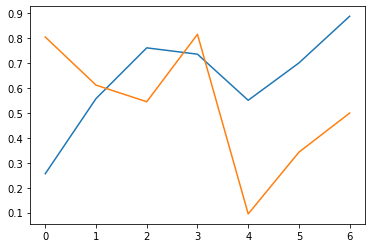

In [86]:
plt.plot(f_measures)